In [29]:
import numpy as np
import math
import matplotlib.pyplot as plt
import gurobipy as gp
from gurobipy import GRB
import plotly.express as px
import pandas as pd

In [167]:
number_of_jobs = 8
max_proc_time = 10
min_proc_time = 1

In [172]:
def optimize_schedule(number_of_jobs, min_proc_time, max_proc_time): 
    w = np.random.rand(number_of_jobs)
    p = np.random.randint(min_proc_time, max_proc_time, number_of_jobs)
    max_time = sum(proc_times_of_jobs)
    L = np.arange(max_time)
    N = np.arange(number_of_jobs)
    try:
    # Create a new model
        m = gp.Model("scheduling1")

        # Create variables, x binary indicator variable that indicates whether job j starts at time time t
        x = m.addVars(N, L, vtype=GRB.BINARY, name="x")


        # Set objective, minimize weighted completion times, NP hard problem
        m.setObjective(sum(x[j,t] * (t + p[j]) * w[j] for t in L for j in N), GRB.MINIMIZE)


        #all jobs must be scheduled and scheduled only once
        m.addConstrs((sum(x[j,t] for t in L) == 1 for j in N), "one")

        #no overlap
        m.addConstrs((sum(x[j,s] for j in N for s in np.arange(max(t-p[j], 0), max(0, t))) <= 1 for t in L), "two")


        # Optimize model
        m.optimize()

    #for v in m.getVars():
    #    print('%s %g' % (v.varName, v.x))

    #print('Obj: %g' % m.objVal)
    
        return m

    except gp.GurobiError as e:
        print('Error code ' + str(e.errno) + ': ' + str(e))

    except AttributeError:
        print('Encountered an attribute error')

In [169]:
def draw_gantt_chart(m):
    df = pd.DataFrame(columns = ['Task', 'Start', 'Finish'])
    for v in m.getVars():
        if v.x == 1:
            txt = v.varName[2:-1].split(",")
            df.loc[len(df.index)] = dict(Task="Job " + txt[0], Start=int(txt[1]), Finish=int(txt[1]) + p[int(txt[0])])
    df['delta'] = df['Finish'] - df['Start']
    fig = px.timeline(df, x_start="Start", x_end="Finish", y="Task")
    fig.update_yaxes(autorange="reversed") # otherwise tasks are listed from the bottom up
    fig.layout.xaxis.type = 'linear'
    fig.data[0].x = df.delta.tolist()
    fig.show()

In [170]:
m =  optimize_schedule(number_of_jobs, min_proc_time, max_proc_time)

Gurobi Optimizer version 9.1.1 build v9.1.1rc0 (mac64)
Thread count: 8 physical cores, 16 logical processors, using up to 16 threads
Optimize a model with 63 rows, 440 columns and 1583 nonzeros
Model fingerprint: 0x6669488e
Variable types: 0 continuous, 440 integer (440 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e-01, 5e+01]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 1e+00]
Found heuristic solution: objective 187.1927753
Presolve removed 1 rows and 0 columns
Presolve time: 0.00s
Presolved: 62 rows, 440 columns, 1583 nonzeros
Variable types: 0 continuous, 440 integer (440 binary)

Root relaxation: objective 1.583708e+01, 48 iterations, 0.00 seconds

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

*    0     0               0      15.8370760   15.83708  0.00%     -    0s

Explored 0 nodes (48 simplex iterations) in 0.02 secon

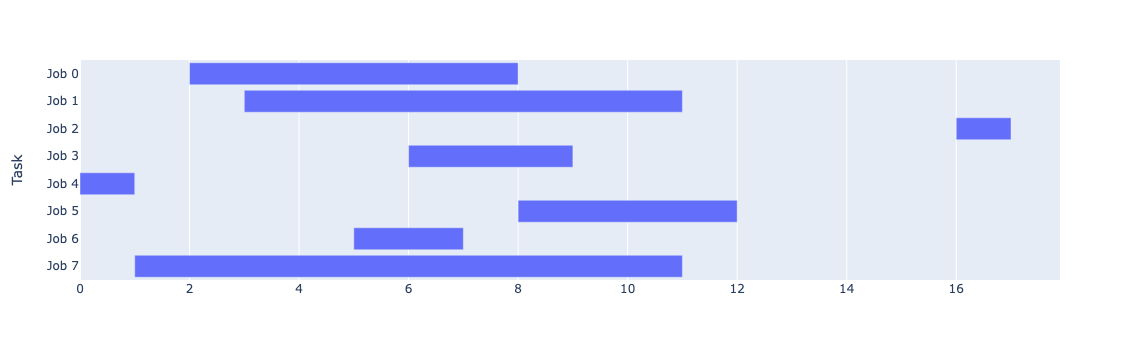

In [171]:
draw_gantt_chart(m)